In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import datetime
import json
from scipy.stats import linregress
from numpy import array

In [ ]:
StrURLPrevIPCA="https://olinda.bcb.gov.br/olinda/servico/Expectativas/versao/v1/odata/ExpectativasMercadoInflacao12Meses?$top=10000&$filter=Indicador%20eq%20'IPCA'%20and%20Suavizada%20eq%20'N'&$format=json&$select=Indicador,Data,Media,Mediana,DesvioPadrao,CoeficienteVariacao,Minimo,Maximo"
StrURLIPCA="http://api.bcb.gov.br/dados/serie/bcdata.sgs.4448/dados?formato=json"
StrURLUSD="https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-1980'&@dataFinalCotacao='01-01-2020'&$top=10000&$format=json&$select=cotacaoVenda,dataHoraCotacao"
StrURLSELIC="https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json"

In [ ]:
def getBACENDATA(columns,StringURL,value=False):
  with urllib.request.urlopen(StringURL) as url: JsonInter=json.loads(url.read())
  df=pd.DataFrame(columns=columns)
  if value:
    for item in JsonInter['value']:
      row=[]
      for column in columns:
        row.append(item[column])
      df.loc[len(df)]=row
  else:
    for item in JsonInter:
      row=[]
      for column in columns:
        row.append(item[column])
      df.loc[len(df)]=row
  return df

In [ ]:
StringURL=StrURLIPCA
columns=['data','valor']
df_IPCA=getBACENDATA(columns,StringURL)


In [ ]:
df_IPCA['fator']=1+(df_IPCA['valor'].astype(float))/100
df_IPCA['fator_acumulado']=1.000000
df_IPCA['fator_acumulado'][0]=df_IPCA['fator'][0]
for i in range(1,len(df_IPCA)):
  df_IPCA['fator_acumulado'][i]=df_IPCA['fator'][i]*df_IPCA['fator_acumulado'][i-1]
df_IPCA['Inflacao_12_Meses']=(df_IPCA['fator_acumulado']/df_IPCA['fator_acumulado'].shift(12)-1)*100
df_IPCA['data']=pd.to_datetime(df_IPCA['data'],format="%d/%m/%Y")
df_IPCA=df_IPCA.rename(columns={"data": "Data",'valor':'IPCA'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


The Data belows contains the monthly Inflation rate (IPCA - Indice de Preços ao Consumidor - Consumer Price Index) as well as the aggregated 12-month inflation (Inflacao_12_Meses)

In [ ]:
df_IPCA.head(20)

,Data,IPCA,fator,fator_acumulado,Inflacao_12_Meses
0,1992-01-01,26.18,1.2618,1.261800,NaN
1,1992-02-01,22.40,1.2240,1.544443,NaN
2,1992-03-01,21.25,1.2125,1.872637,NaN
3,1992-04-01,18.96,1.1896,2.227689,NaN
4,1992-05-01,25.52,1.2552,2.796196,NaN
5,1992-06-01,19.72,1.1972,3.347606,NaN
6,1992-07-01,21.79,1.2179,4.077049,NaN
7,1992-08-01,20.31,1.2031,4.905097,NaN
8,1992-09-01,25.02,1.2502,6.132353,NaN
9,1992-10-01,24.41,1.2441,7.629260,NaN


In [ ]:
StringURL=StrURLPrevIPCA
columns=['Indicador','Data','Media','Mediana','DesvioPadrao','CoeficienteVariacao','Minimo','Maximo']
df_IPCA_Prev=getBACENDATA(columns,StringURL,True)

In [ ]:
df_IPCA_Prev['Date_Prediction']=pd.to_datetime(df_IPCA_Prev['Data'])+datetime.timedelta(days=365)
df_IPCA_Prev['Data']=pd.to_datetime(df_IPCA_Prev['Data'],format='%Y-%m-%d')

The below data contains Predictions for future 12-month inflation made by brazilian financial institutions and delivered to the Central bank of Brazil.

The columns are:
Indicador=the index for which the date referes to, in our case, only IPCA
Data=Date in which prediction was made
Media=Average
Mediana=Median
DesvioPadrao=Standard Deviation
CoeficienteVariacao=(Standard Deviation/Average)*100
Minimo=min
Maximo=max
Date_Prediction=12M after the prediction date.

In [ ]:
df_IPCA_Prev.head(20)

,Indicador,Data,Media,Mediana,DesvioPadrao,CoeficienteVariacao,Minimo,Maximo,Date_Prediction
0,IPCA,2018-01-22,3.97,3.95,0.25,6.30,3.35,4.82,2019-01-22
1,IPCA,2018-01-23,3.97,3.95,0.25,6.30,3.35,4.82,2019-01-23
2,IPCA,2018-01-24,3.97,3.95,0.25,6.30,3.35,4.82,2019-01-24
3,IPCA,2018-01-25,3.97,3.95,0.25,6.30,3.35,4.82,2019-01-25
4,IPCA,2018-01-26,3.98,3.95,0.25,6.28,3.35,4.82,2019-01-26
5,IPCA,2018-01-29,3.98,3.95,0.25,6.28,3.35,4.82,2019-01-29
6,IPCA,2018-01-30,3.98,3.95,0.26,6.53,3.35,4.82,2019-01-30
7,IPCA,2018-01-31,3.98,3.95,0.26,6.53,3.35,4.82,2019-01-31
8,IPCA,2018-02-01,3.98,3.95,0.25,6.28,3.47,4.82,2019-02-01
9,IPCA,2018-02-02,3.97,3.94,0.26,6.55,3.47,4.82,2019-02-02


In [ ]:
min(df_IPCA_Prev['Data'])

Timestamp('2001-11-07 00:00:00')

Bellow data contais the USD/Brazilian currency Exchange Ratio, due to hyperinflation, the name of the currency has changed during the period of this data.

Most recent (since 07-1994) name of Brazilian currency is Real (BRL)

In [ ]:
StringURL=StrURLUSD
columns=['cotacaoVenda','dataHoraCotacao']
df_USD=getBACENDATA(columns,StringURL,True)
df_USD['dataHoraCotacao']=df_USD['dataHoraCotacao'].values.astype('<M8[D]')
df_USD['dataHoraCotacao']=pd.to_datetime(df_USD['dataHoraCotacao'],format="%d/%m/%Y")
df_USD=df_USD.rename(columns={"cotacaoVenda": "USD_2_BRL","dataHoraCotacao":"Data"})
df_USD.head(10)

,USD_2_BRL,Data
0,2828.0,1984-12-03
1,2828.0,1984-12-03
2,2881.0,1984-12-04
3,2881.0,1984-12-05
4,2881.0,1984-12-05
5,2923.0,1984-12-05
6,2923.0,1984-12-06
7,2923.0,1984-12-07
8,2965.0,1984-12-10
9,2965.0,1984-12-11


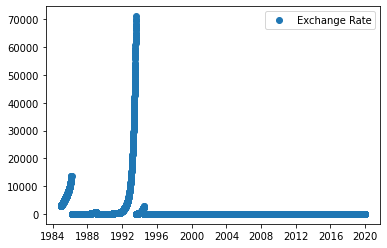

In [ ]:
import matplotlib.pyplot as plt
x_chart=pd.to_datetime(df_USD['Data'])
y_chart=df_USD['USD_2_BRL']

plt.plot(x_chart, y_chart, 'o', label='Exchange Rate')
plt.legend()
plt.show()

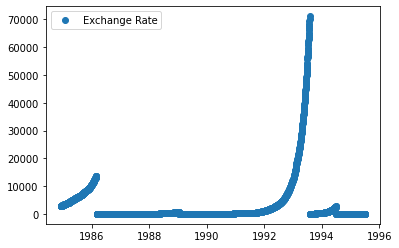

In [ ]:
x_chart=pd.to_datetime(df_USD['Data'][:int(len(df_USD)*0.3)])
y_chart=df_USD['USD_2_BRL'][:int(len(df_USD)*0.3)]

plt.plot(x_chart, y_chart, 'o', label='Exchange Rate')
plt.legend()
plt.show()

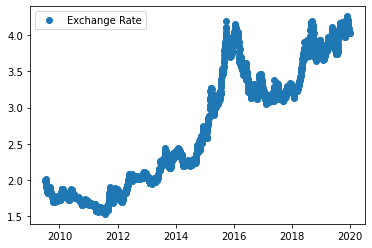

In [ ]:
x_chart=pd.to_datetime(df_USD['Data'][len(df_USD)-int(len(df_USD)*0.3):])
y_chart=df_USD['USD_2_BRL'][len(df_USD)-int(len(df_USD)*0.3):]

plt.plot(x_chart, y_chart, 'o', label='Exchange Rate')
plt.legend()
plt.show()

SELIC (Central Bank base rate) for overnight Repo/Reverse Repo operations.

In [ ]:
StringURL=StrURLSELIC
columns=['data','valor']
df_SELIC=getBACENDATA(columns,StringURL)
df_SELIC['data']=pd.to_datetime(df_SELIC['data'],format="%d/%m/%Y")
df_SELIC=df_SELIC.rename(columns={"valor": "Daily_Base_Interest_Rate",'data':'Data'})
df_SELIC.head(10)

,Data,Daily_Base_Interest_Rate
0,1986-06-04,0.065041
1,1986-06-05,0.067397
2,1986-06-06,0.066740
3,1986-06-09,0.068247
4,1986-06-10,0.067041
5,1986-06-11,0.066740
6,1986-06-12,0.066575
7,1986-06-13,0.066164
8,1986-06-16,0.066493
9,1986-06-17,0.066247


In [ ]:
df=df_IPCA[['Data',	'IPCA','Inflacao_12_Meses']].merge(df_USD, left_on='Data', right_on='Data')
df=df.merge(df_SELIC, left_on='Data', right_on='Data')
df['Inflacao_12_Meses_Shift']=df['Inflacao_12_Meses'].shift(-12)
df['USD_2_BRL_Variation']=df['USD_2_BRL'].pct_change()


Bellow we will construct a linear model between four variables (Monthly Inflation, Monthly USD/BRL exchange rate percentual variation, Base interest rate and cumulative inflation on the previous 12 months) and our target value in order to confirm if there is any relationship between them

In [ ]:
#Data exploration:
X=df.dropna(how='any')[['IPCA','USD_2_BRL_Variation','Daily_Base_Interest_Rate','Inflacao_12_Meses']]
Y=df.dropna(how='any')['Inflacao_12_Meses_Shift']

for column in X.columns:
        x=np.array(X[column],dtype=np.float32)
        y=np.array(Y,dtype=np.float32)
        slope, Intercept, r_value, p_value, std_err = linregress(x,y)
        print('Analysis for: ' + column +' vs Future Inflation:')
        print('p_value: '+str(p_value))
        print('R-Squared: '+str(r_value**2))

Analysis for: IPCA vs Future Inflation:
p_value: 3.9022881402400923e-10
R-Squared: 0.19897545195951064
Analysis for: USD_2_BRL_Variation vs Future Inflation:
p_value: 0.0009864777146704018
R-Squared: 0.059635465282588604
Analysis for: Daily_Base_Interest_Rate vs Future Inflation:
p_value: 1.1804946786027202e-12
R-Squared: 0.24888992823722614
Analysis for: Inflacao_12_Meses vs Future Inflation:
p_value: 0.0005769016381291179
R-Squared: 0.06492842819910233


All variables have significative p-values. Their individual R-Squared is small, but significative. therefore we will proceed with all of them in the LSTM Model

In [ ]:
df=df.merge(df_IPCA_Prev[['Date_Prediction','Media']],left_on='Data',right_on='Date_Prediction',how='left')

The data frame below contains data from all other dataframes mentioned previously.

the column Inflacao_12_Meses_Shift will be used as our target value, it consist on Inflacao_12_meses, shifted from 12 positions, in order to sinalize which will be the future inflation.

In [ ]:
df.head(10)

,Data,IPCA,Inflacao_12_Meses,USD_2_BRL,Daily_Base_Interest_Rate,Inflacao_12_Meses_Shift,USD_2_BRL_Variation,Date_Prediction,Media
0,1992-04-01,18.96,NaN,2007.10,1.176000,1897.696697,NaN,NaT,NaN
1,1992-06-01,19.72,NaN,2874.50,1.034667,2105.622575,0.432166,NaT,NaN
2,1992-07-01,21.79,NaN,3475.90,1.012667,2324.916925,0.209219,NaT,NaN
3,1992-09-01,25.02,NaN,5184.60,1.170667,2947.467963,0.491585,NaT,NaN
4,1992-10-01,24.41,NaN,6468.50,1.202667,3346.756827,0.247637,NaT,NaN
5,1992-12-01,23.51,NaN,10046.20,1.032667,4732.350501,0.553096,NaT,NaN
6,1993-02-01,24.79,1117.641018,15931.25,1.425333,3170.988907,0.585799,NaT,NaN
7,1993-03-01,27.84,1183.820435,20062.00,1.201667,2405.807274,0.259286,NaT,NaN
8,1993-04-01,25.63,1255.803305,25444.50,1.385000,1421.763167,0.268293,NaT,NaN
9,1993-06-01,29.20,1389.856356,42239.65,1.365667,1050.259750,0.660070,NaT,NaN


In [ ]:
df.tail(20)

,Data,IPCA,Inflacao_12_Meses,USD_2_BRL,Daily_Base_Interest_Rate,Inflacao_12_Meses_Shift,USD_2_BRL_Variation,Date_Prediction,Media
205,2018-03-01,0.18,3.097573,3.2620,0.025552,NaN,0.028049,2018-03-01,4.49
206,2018-06-01,0.38,3.109641,3.7413,0.024620,NaN,0.146934,2018-06-01,4.64
207,2018-06-01,0.38,3.109641,3.7413,0.024620,NaN,0.146934,2018-06-01,4.52
208,2018-08-01,-0.31,2.790478,3.7491,0.024620,NaN,0.002085,2018-08-01,4.48
209,2018-08-01,-0.31,2.790478,3.7491,0.024620,NaN,0.002085,2018-08-01,4.64
210,2018-10-01,0.40,2.944280,4.0273,0.024620,NaN,0.074204,NaT,NaN
211,2018-11-01,0.64,3.623848,3.6973,0.024620,NaN,-0.081941,2018-11-01,4.14
212,2018-11-01,0.64,3.623848,3.6973,0.024620,NaN,-0.081941,2018-11-01,4.16
213,2019-02-01,0.85,4.253483,3.6694,0.024620,NaN,-0.007546,2019-02-01,3.98
214,2019-02-01,0.85,4.253483,3.6694,0.024620,NaN,-0.007546,2019-02-01,4.01


In [ ]:
df.shape

(225, 9)

In [ ]:
#date that splits dataframe in train-test sets
df['Data'][int(df.shape[0]*0.7)]

Timestamp('2014-07-01 00:00:00')

In [ ]:
df=df.dropna(subset=['IPCA','USD_2_BRL_Variation','Daily_Base_Interest_Rate','Inflacao_12_Meses','Inflacao_12_Meses_Shift'], how='any')
df.shape

(198, 9)

In [ ]:
#model construction
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf

Inspired on https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=Multi%2DStep%20Output.-,Univariate%20LSTM%20Models,next%20value%20in%20the%20sequence.

In [ ]:
n_steps=12
n_features=X.values.shape[1]

Keras LSTM must receive data in a 3D shape: (Samples, Timesteps,Features), We will consider timestep as 12 (equivalent to previous one year) and Keep the features studied in the p-value and R-Squared modelling above

In [ ]:
def split_sequence(df,Y,n_steps):
  columns=list(df.columns)
  X, y = list(), list()
  for i in range(len(df)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(df)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = df[columns][i:end_ix].values, Y[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y).reshape(-1,1)

In [ ]:
X,Y_fin=split_sequence(df[['IPCA','USD_2_BRL_Variation','Daily_Base_Interest_Rate','Inflacao_12_Meses']],df['Media'],n_steps)
X,Y=split_sequence(df[['IPCA','USD_2_BRL_Variation','Daily_Base_Interest_Rate','Inflacao_12_Meses']],df['Inflacao_12_Meses_Shift'],n_steps)

X is the independent variables, Y is the future 12-month inflation, Y-fin is the future 12-month inflation predicted by the brazilian financial institutions

In [ ]:
print("X Shape: "+str(X.shape))
print("Y Shape: "+str(Y.shape))
print("Y_fin Shape: "+str(Y_fin.shape))

X Shape: (186, 12, 4)
Y Shape: (186, 1)
Y_fin Shape: (186, 1)


In [ ]:
#Model Definition
n_neurons_dense=64
dropout_ratio=0.3
model=Sequential()
model.add(LSTM(100,dropout=dropout_ratio,recurrent_dropout=dropout_ratio,input_shape=(n_steps,n_features)))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense,activation='tanh'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/2,activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/(2**2),activation='softmax'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse')

We will do a 70%-30% Train-Test sets splits, the Test set will be the most recent data avaliable

In [ ]:
#train and test set selection:
X_train=X[:int(df.shape[0]*0.7),:,:]
X_test=X[-(len(X)-int(df.shape[0]*0.7)):,:,:]

In [ ]:
Y_Train=Y[:int(df.shape[0]*0.7)]
Y_Test=Y[-(len(X)-int(df.shape[0]*0.7)):]
Y_fin_Test=Y_fin[-(len(X)-int(df.shape[0]*0.7)):]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(138, 12, 4)
(48, 12, 4)


In [ ]:
model.fit(X_train.astype(np.float32), Y_Train.astype(np.float32), epochs=350, verbose=1)

Epoch 1/350
5/5 [==============================] - 0s 17ms/step - loss: 141.7420
Epoch 2/350
5/5 [==============================] - 0s 17ms/step - loss: 139.6844
Epoch 3/350
5/5 [==============================] - 0s 17ms/step - loss: 138.9377
Epoch 4/350
5/5 [==============================] - 0s 18ms/step - loss: 137.5795
Epoch 5/350
5/5 [==============================] - 0s 17ms/step - loss: 135.8827
Epoch 6/350
5/5 [==============================] - 0s 20ms/step - loss: 134.1169
Epoch 7/350
5/5 [==============================] - 0s 17ms/step - loss: 133.2580
Epoch 8/350
5/5 [==============================] - 0s 17ms/step - loss: 133.7236
Epoch 9/350
5/5 [==============================] - 0s 18ms/step - loss: 132.9335
Epoch 10/350
5/5 [==============================] - 0s 17ms/step - loss: 131.2837
Epoch 11/350
5/5 [==============================] - 0s 17ms/step - loss: 129.7591
Epoch 12/350
5/5 [==============================] - 0s 17ms/step - loss: 131.3414
Epoch 13/350
5/5 [=======

In [ ]:
Y_pred=model.predict(X_test.astype(np.float32))

In The model evaluation we will comparte the mean squared error between our model's predictions vs the True inflation as well as the MSE between the Financial institutions predictions and the true inflations.

Predictions made by our model for dates that no data is avaliable for the financial institutions will not be considered in this analysis. 

In [ ]:
#Model Evaluation:

from sklearn.metrics import mean_squared_error

df_result=pd.DataFrame()
df_result['Ground_Truth']=Y_Test.reshape(1,-1)[0]
df_result['NN_Prediction']=Y_pred.reshape(1,-1)[0]
df_result['FI_Prediction']=Y_fin_Test.reshape(1,-1)[0]
df_result=df_result.dropna(how='any')

#Mean Squared error of neural network prediction:
print("Mean Squared Error of neural network prediction: "+str(mean_squared_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))
#Mean squared error of predictions from Financial Institutions:
print("Mean Squared Error of predictions from Financial Institutions: "+str(mean_squared_error(df_result['Ground_Truth'],df_result['FI_Prediction'])))

Mean Squared Error of neural network prediction: 6.162676151752825
Mean Squared Error of predictions from Financial Institutions: 7.155896426248233
